Импорт библиотек

In [1]:
from matplotlib import pyplot
from scipy.stats import sigmaclip
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas
import seaborn as sns
import numpy
from sklearn import svm
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, cross_val_predict
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB
import seaborn
from MAD2 import *
import warnings

warnings.filterwarnings('ignore')

# Вывести информацию о наборе данных


Чтение данных

In [2]:
categorical = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']
numeric = ['Fare', 'Age']
train_frame = pandas.read_csv("train.csv")
train_frame

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
1,426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
2,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
3,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
4,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
...,...,...,...,...,...,...,...,...,...,...,...,...
529,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
530,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.0750,NaN,S
531,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
532,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S


Обработка train_frame

In [3]:
print(train_frame.isna().sum())
output = train_frame['Survived']
train_frame = process_frame(train_frame, categorical, numeric, ["Cabin", "PassengerId", "Ticket", "Name"])
input_frame = train_frame.drop(columns='Survived')
print(f"Оставшиеся столбцы: {train_frame.columns.values}")

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            102
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          414
Embarked         0
dtype: int64
Оставшиеся столбцы: ['Survived' 'Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked']


In [4]:
train_columns = {'all_columns': input_frame.columns.values}

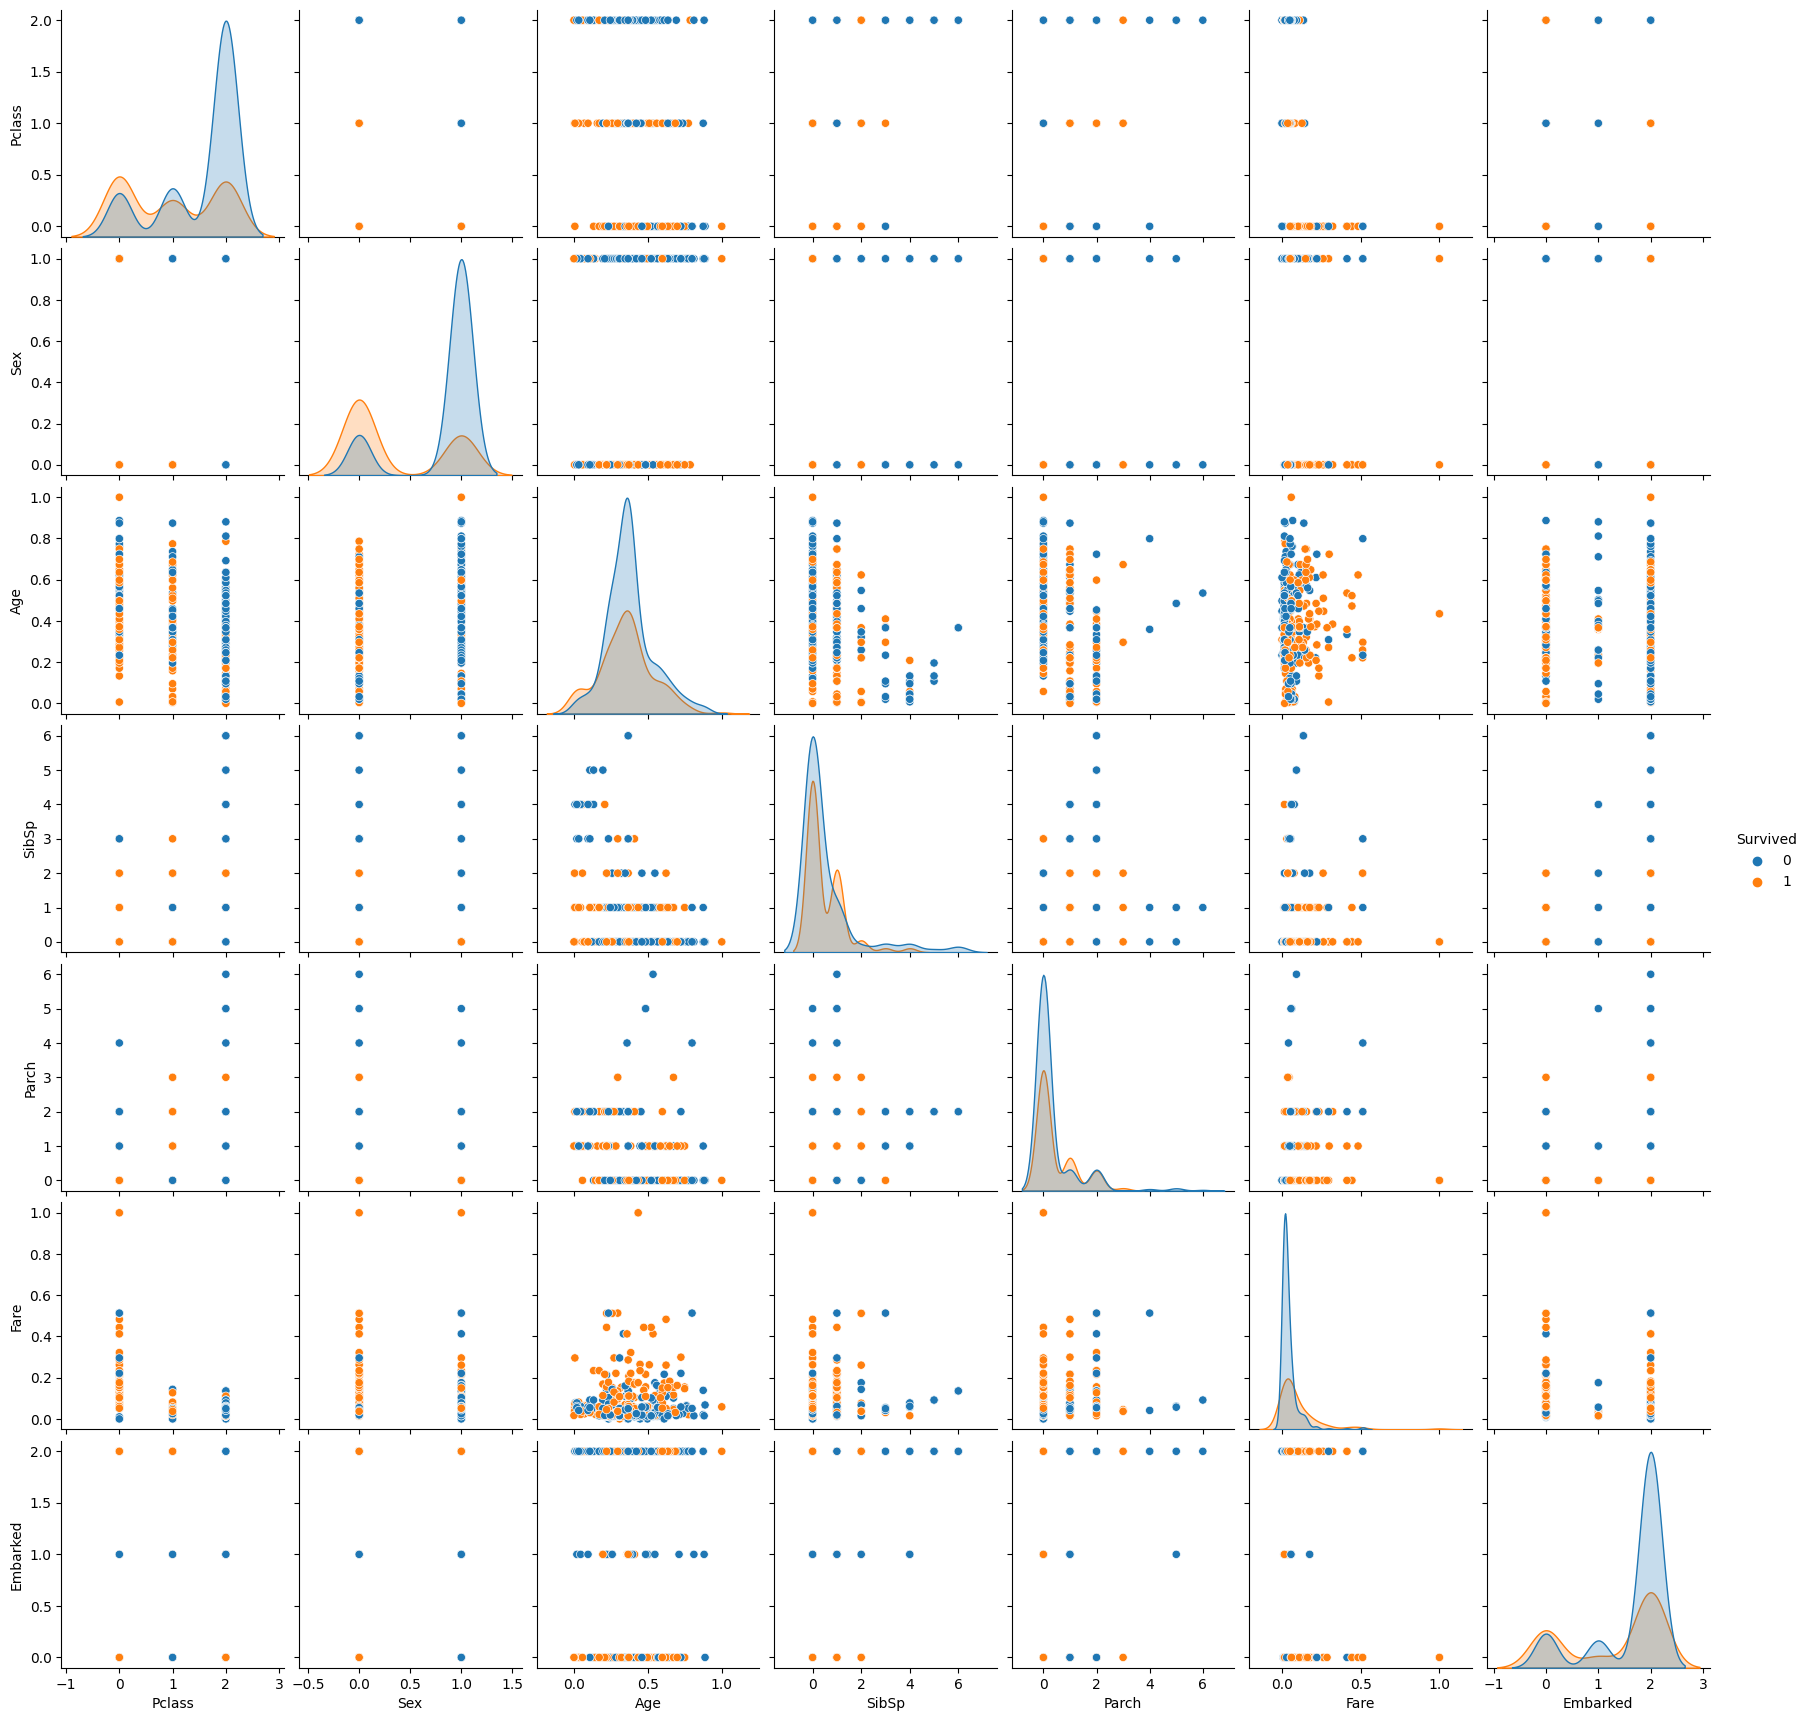

In [5]:
seaborn.pairplot(train_frame, hue='Survived')
pyplot.show()

Отбор признаков методом обертки

In [6]:
estimator = LinearSVC()
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(train_frame.drop(columns = "Survived"), train_frame["Survived"])
print(list(selector.get_feature_names_out()))
train_columns['linear_SVC'] = list(selector.get_feature_names_out())

['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked']


Отбор признаков фильтрацией

In [7]:
kbest = SelectKBest(k=5, score_func=chi2)
kbest_frame = kbest.fit_transform(train_frame, output)
columns = list(kbest.get_feature_names_out())
columns.remove('Survived')
train_columns['kbest'] = columns
columns

['Pclass', 'Sex', 'Fare', 'Embarked']

Отбор признаков встроенными методами

In [8]:
model = Lasso(alpha=0.01)
model.fit(train_frame.drop(columns = "Survived"), train_frame["Survived"])
selected_features_lasso = train_frame.drop(columns = "Survived").columns[model.coef_ != 0]
selected_features_lasso = list(selected_features_lasso)
train_columns["embedded_methods"] = list(selected_features_lasso)

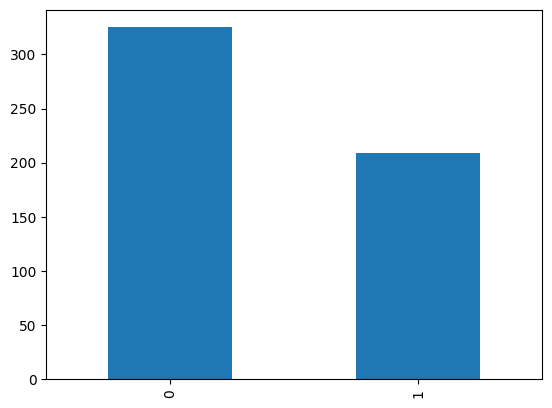

In [9]:
output.value_counts().plot(kind='bar')
pyplot.show()

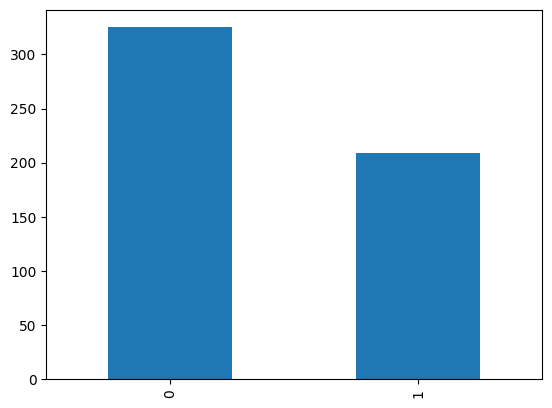

In [10]:
output.value_counts().plot(kind='bar')
pyplot.show()

In [12]:
results = []
for c in train_columns:
    frame = train_frame[train_columns[c]]
    frame = frame.join(output)
    samples = create_samples(frame)
    for s in samples:
        print(c, s)
        x_train, x_val, y_train, y_val = train_test_split(samples[s].drop(columns='Survived'), samples[s]["Survived"], test_size = 0.3, random_state=0)
        logistic_clf = logistic_regression(x_train, y_train)
        results.append((c, s, logistic_clf, roc_auc_score(y_val, logistic_clf.predict(x_val))))
        kn_clf = kneighbours(x_train, y_train)
        results.append((c, s, kn_clf, roc_auc_score(y_val, kn_clf.predict(x_val))))
        gaus_clf = gaussian(x_train, y_train)
        results.append((c, s, gaus_clf, roc_auc_score(y_val, gaus_clf.predict(x_val))))
        disc_clf = discriminant_analysis(x_train, y_train)
        results.append((c, s, disc_clf, roc_auc_score(y_val, disc_clf.predict(x_val))))
        vector_clf = vector_classification(x_train, y_train)
        results.append((c, s, vector_clf, roc_auc_score(y_val, vector_clf.predict(x_val))))


all_columns No_sampling
all_columns Oversampling
all_columns Undersampling
linear_SVC No_sampling
linear_SVC Oversampling
linear_SVC Undersampling
kbest No_sampling
kbest Oversampling
kbest Undersampling
embedded_methods No_sampling
embedded_methods Oversampling
embedded_methods Undersampling


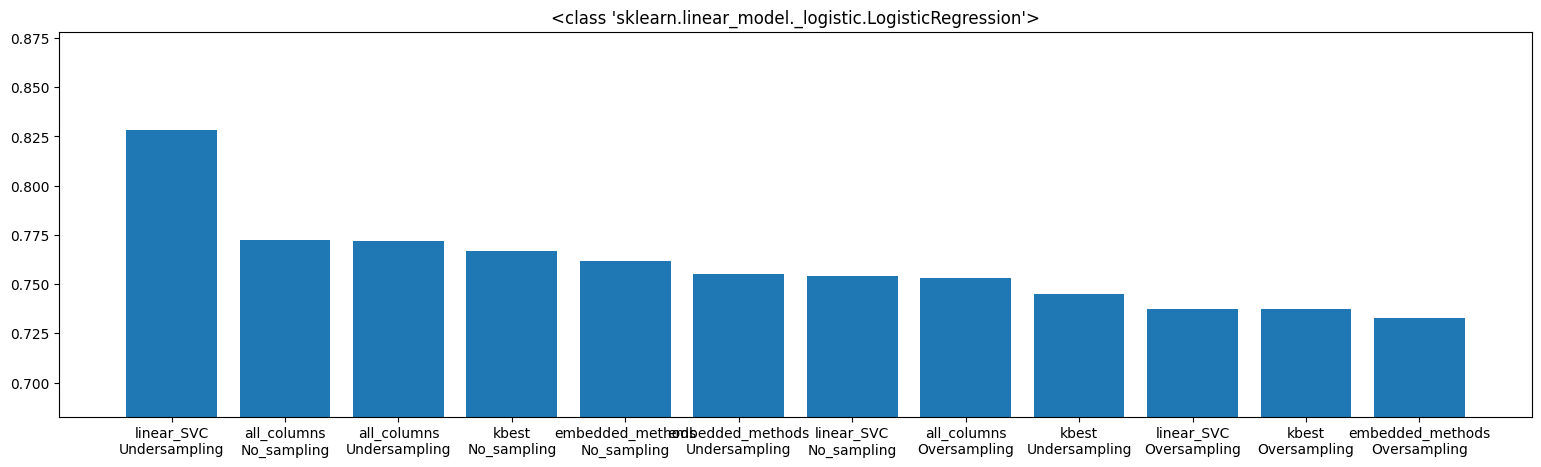

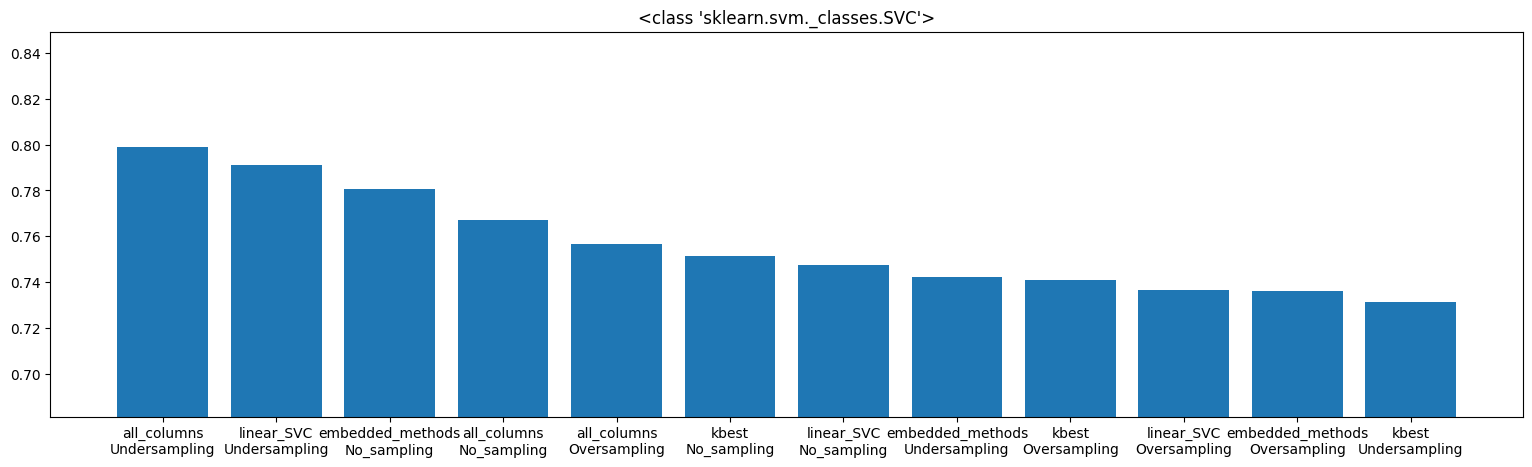

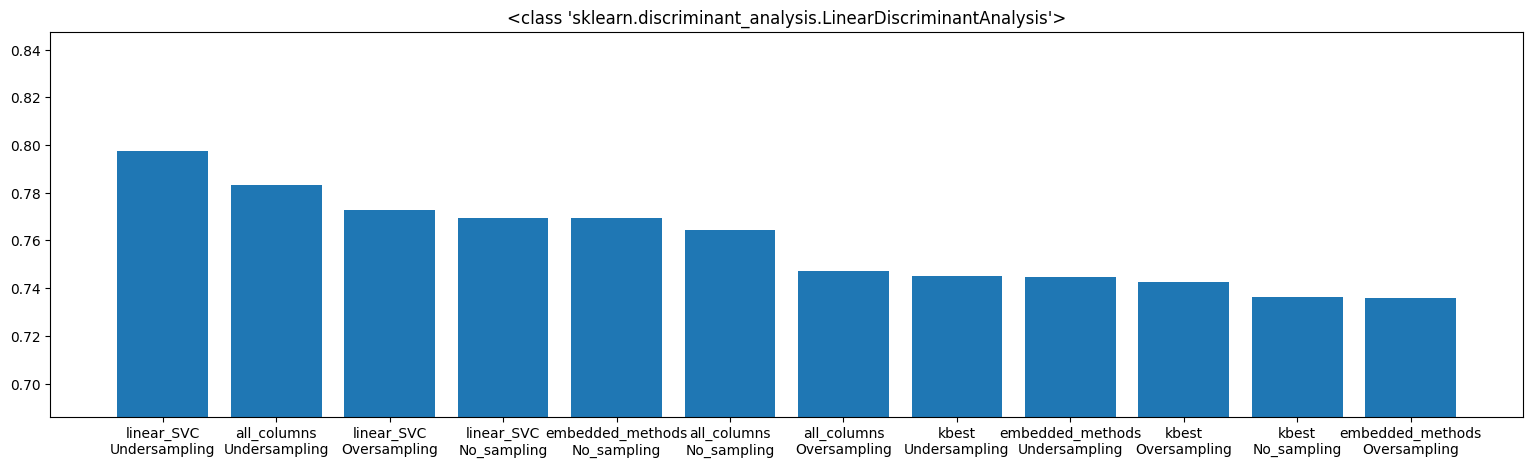

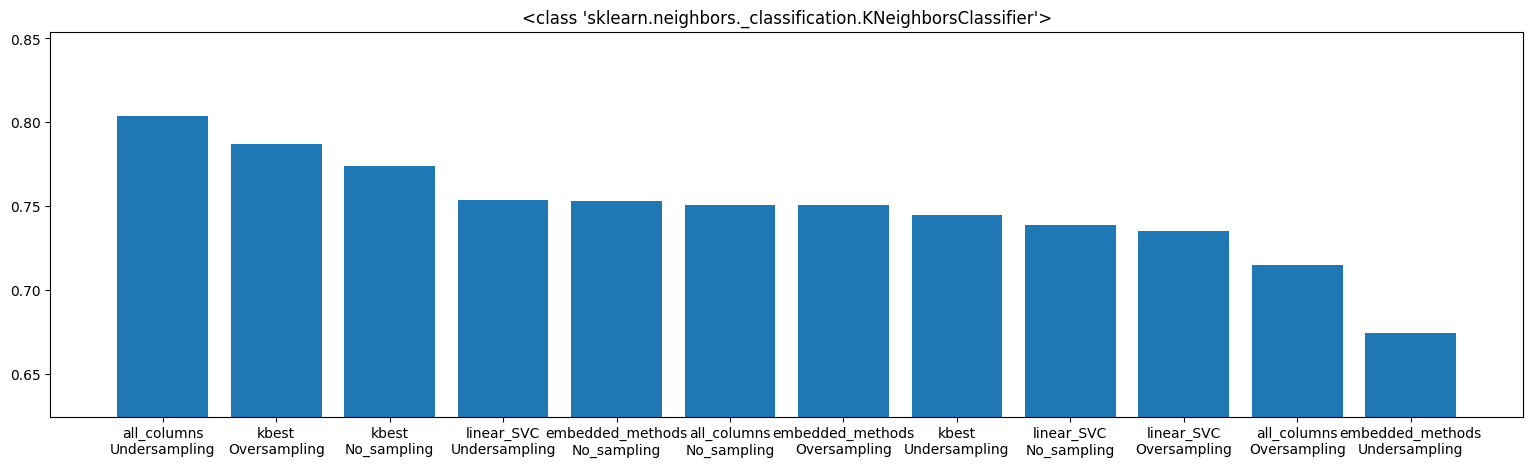

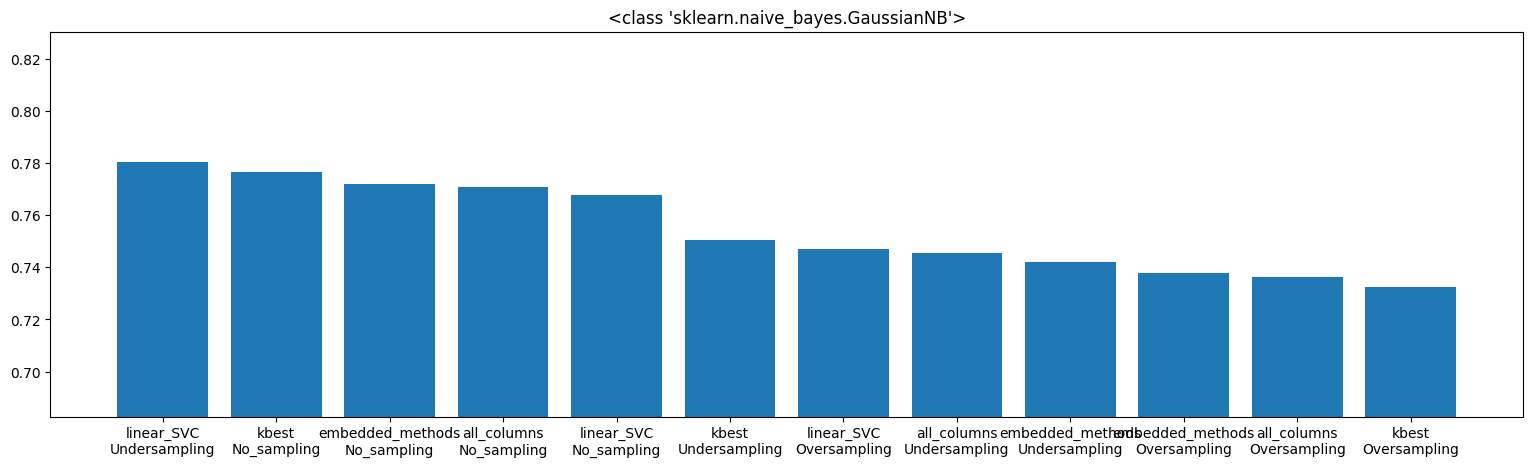

In [16]:
for clf, color in ((LogisticRegression, 'red'), (SVC, 'blue'), (LinearDiscriminantAnalysis, 'yellow'), 
                   (KNeighborsClassifier, 'green'), (GaussianNB, 'pink')):
    clfs = list(filter(lambda x: type(x[2]) == clf, results))
    groups = [f"{x[0]}\n{x[1]}" for x in clfs]
    counts = [x[3] for x in clfs]
    fig, ax = pyplot.subplots()
    ax.set_title(str(clf))
    fig.set_size_inches(19, 5)
    pyplot.ylim([min(counts) - 0.05, max(counts) + 0.05])
    pyplot.bar(groups, counts)

In [14]:
results.sort(key = lambda x: x[3], reverse=True)
for x in range(5):
    print(results[x])

('linear_SVC', 'Undersampling', LogisticRegression(C=2, l1_ratio=0.5, penalty=None, solver='saga'), 0.8281644428416877)
('all_columns', 'Undersampling', KNeighborsClassifier(n_neighbors=7), 0.803994344291269)
('all_columns', 'Undersampling', SVC(C=1, max_iter=1000), 0.7990455991516437)
('linear_SVC', 'Undersampling', LinearDiscriminantAnalysis(), 0.797421565091958)
('linear_SVC', 'Undersampling', SVC(C=3, max_iter=1000), 0.7911107104219257)


Чтение и обработка тестовой выборки

In [15]:
# Чтение данных
test_frame = pandas.read_csv("test.csv")
passenger_id = test_frame['PassengerId']
test_frame = process_frame(test_frame, categorical, numeric, ["Cabin",  "Ticket", "Name", "PassengerId"])
# Удаление лишних столбцов
columns = train_columns[results[0][0]]
if 'Parch_6' in columns:
    test_frame.insert(len(columns), 'Parch_6', 0)
print(columns)
test_frame = test_frame[columns]
clf = results[0][2]
test_frame["Survived"] = clf.predict(test_frame)
test_frame['PassengerId'] = passenger_id
print(test_frame[['PassengerId', 'Survived']])
test_frame[['PassengerId', 'Survived']].to_csv("predicted_test.csv", index=False)

['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked']
     PassengerId  Survived
0            384         1
1            882         0
2            276         1
3            648         0
4            224         0
..           ...       ...
352          115         1
353          539         0
354          656         0
355           11         1
356          308         1

[357 rows x 2 columns]


###### x_test = test_frame
predicted_y_test = lsvc.predict(x_test)